![](https://upload.wikimedia.org/wikipedia/commons/3/38/Forest_panorama_2.jpg "Machine learning from woods - exploring tree-based ensemble models")

# Machine Learning from the Woods: Exploring Tree-Based Ensemble Models in Python

### Intro

Python is a hot topic right now. So is machine learning. And ensemble models.

Put the three together, and you have a mighty combination of powerful technologies.

**This article provides an extensive overview of tree-based ensemble models and the many applications of Python in machine learning. Read on to learn why these models are the perfect solution for numerous machine learning problems.**

Here’s what we’re going to cover:

* **First, I’ll give you some basic theory behind three ensemble models: random forests, AdaBoost, and gradient tree boosting.**
* **Next, I’ll teach you how to implement those ensemble models using one of [the most popular Python libraries](https://stxnext.com/blog/2017/04/12/most-popular-python-scientific-libraries/) for machine learning: scikit-learn.**
* **Lastly, I’ll show you how to improve the out-of-the-box performance of your ensemble models.**

Even though they are relatively easy to understand, ensemble models are the winning algorithms in plenty of data science competitions (organized by Kaggle or DrivenData, just to name a few). What’s more, they usually don’t require large clusters of GPU-accelerated machines to achieve reasonable results.

You don’t need to be a machine learning expert or a math genius to understand this text. The general idea behind ensemble models is really simple—[even pigeons could understand it!](https://www.theguardian.com/society/2015/nov/19/pigeons-can-identify-cancerous-tissue-on-x-rays-study-finds) 

Here’s a recipe: get a set of models, aggregate their predictions, and that’s it, you’re good to go!

There are, of course, many tricks to getting the best results from ensembles, and we’ll discuss those later. Also, I will be getting quite technical most of the time, so it would be easier if you were familiar with at least some of the core principles behind supervised learning. But for now, you have everything you need.

One last thing you might be wondering and I’d like to address before we begin: what’s up with that title?

“Machine learning from the woods?” Why “woods”? Follow-up question: what does it mean that the models are “tree-based”?

Well, as it turns out, the most commonly used algorithms to combine into ensembles are decision trees. Get it?

Note: this article is available in two versions: here and on the [STX Blog](https://stxnext.com/blog/2018/09/04/machine-learning-ensemble-models-python/).

### ML Background

I’ll start by briefly introducing two crucial concepts: **bias and variance.** They describe the dependency between model complexity and data.

High bias means your model is too general and ignores many important patterns. Conversely, high variance occurs when a model “focuses” on cosmetic details too much, losing sight of the big picture, data-wise. **Finding an optimal model is always a trade-off between bias and variance.**

In the following sections, we will solve the **classification problem**. This means we’ll assign a label to an observation class, based on certain features that describe it.

In our case, the observation is a person applying for a credit card. That person is described by age, income, and number of children, among others—all of these are our features. We will build a model that decides whether that person should receive a credit card based on the specified features. To put it another way: we’ll give the class an “accepted” or “rejected” label.

Without further ado—before we dive into the workings of random forests, AdaBoost, and gradient tree boosting—let’s spend a minute talking about **their building blocks: decision trees.**

### Decision Trees

Simply put, **decision trees are models built with a set of Boolean conditions, defined by data features** (e.g. “if the age is less than 18”). These conditions are presented in the form of a binary tree.

To train a decision tree means to locate these conditions (decision boundaries) using given [criteria](http://scikit-learn.org/stable/modules/tree.html#classification-criteria). Let’s look at a sample tree to show how these boundaries interact with each other.

We’ll create a simple dataset, where each of 100 samples is defined by only two features (dimensions): X and Y. There will be three classes: “red”, “green,” and “blue.”

The `make_blobs` function from the scikit-learn library makes the job easy for us.

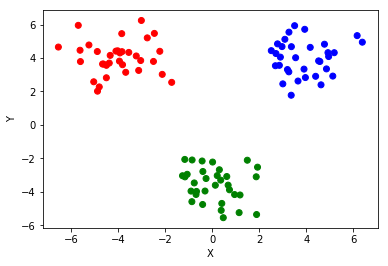

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

%matplotlib inline

RANDOM_STATE = 0  # Ensure repeatability when using randomness
COLORS = ["red", "green", "blue"]
FEATURES_NAMES = ["X", "Y"]

features, labels = make_blobs(
    centers=[(-4, 4), (0, -4), (4, 4)],
    random_state=RANDOM_STATE
)
labels_colors = [COLORS[label] for label in labels]

plt.scatter(features[:, 0], features[:, 1], c=labels_colors)
plt.xlabel(FEATURES_NAMES[0])
plt.ylabel(FEATURES_NAMES[1])
plt.show()

Then, we can create our tree classifier.

All scikit-learn's models share the same API for training: `fit(features, labels)`.

In [2]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Finally, we will use graphviz library to investigate the structure of out tree classifier.

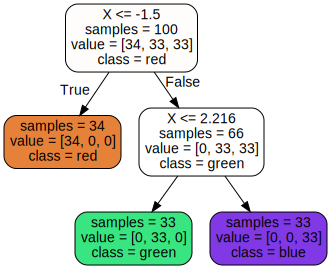

In [3]:
import graphviz
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
    decision_tree=decision_tree,
    out_file=None,
    feature_names=FEATURES_NAMES,
    class_names=COLORS,
    rounded=True,
    filled=True,
    impurity=False
)
tree_graph = graphviz.Source(tree_data)
tree_graph

The first row in the node describes the decision boundary and isn’t present in the leaves, since they do not split.

The next one is the number of samples falling into that node, followed by sample distribution between classes.

The last one is the most common class in the node, which in the leaves is interpreted as the tree output label.

As you can see, decision trees handled this little example well; in fact, they can deal with many real-life problems. What is more, the models are **interpretable** and **easy to visualize.**

Decision trees also don’t require a whole lot of data preprocessing. For example, you don’t need to scale the data, because the trees won’t care about feature magnitude to find the decision boundary.

In addition, **decision trees can handle both numerical and categorical data,** although they are quite prone to overfitting, meaning they are high-variance models.

As a result, small changes to the training set can result in major decision boundary shifts. One of the most successful ways to solve this issue is to use many trees to make decisions.

Here’s what’d like you to remember from this section the most: **if you answer plenty of small yes/no questions, the decision tree will tell you the truth.**

### Random Forest

You may be asking yourself: **how can using many overfitted models decrease classifier error?** Well, let me try and answer that for you.

Overfitted trees make decisions based on some generally uncommon observations. However, they still hold valuable data insights.

When using a large number of such trees, the rarest and weirdest cases disappear. The more common ones, though, remain and play an important part in making the classifier more “open-minded.”

**Imagine this as a group of people who reach a consensus by discarding their most extreme views.** In the human world, it doesn’t always work that well, but decision trees are more dovish creatures.

We’ve already seen that tree classifier variety is a rather desirable feature. If we had multiple datasets from multiple sources, we could make our trees even more skewed. But how do we do that with only one dataset available?

That’s where the idea of **bagging (or bootstrap aggregating)** comes to the rescue.

Let’s say you have 1,000 samples in your training set. You want to create 25 new training sets to train 25 different decision trees. What you do is simply **pick 1,000 samples at random** (with replacements) from your training set (bag).

In the new training set, some samples from the original set will appear more than once, while some won’t appear at all. If you repeat this procedure 25 times, you’ll have 25 different training sets for building your trees. To get the final prediction of an ensemble, you just pick the most common output of all trees.

You may also use probabilities of classes instead of just labels. You can take them from a distribution of class representatives in final tree node (leaf). Using this approach, your model will favor more reliable trees, which is only reasonable.

But the random forest is more than just bagging trees. There is another trick to make individual trees even more diverse. You can **randomly limit the set of features available** when splitting a node.

This way, each time when a tree tries to find an optimal decision boundary, it “sees” a subset of all features. This draw takes place each time a node is split. A common measure is to randomly take sqrt(n) or log2(n) features to make a split where n is the original number of features.

Long story short: **take a lot of different trees and stack their results; the least popular cases will fall by the wayside, while the more common ones will grow in strength.**


### AdaBoost

There is another family of ensembling methods called **boosting.** It tackles the problem of stacking a great deal of classifiers from the other side.

This time, we’ll use multiple weak learners, which is only a slight improvement over random guessing. Again, cooperative deciding makes it powerful, since individual classifiers often are too primitive. However, if there is a sufficient number of them, frequent insights can be treated as valuable. **Such an approach helps us reduce general bias using many high-bias models.**

The trees making up the AdaBoost ensemble are created sequentially. Once a tree is trained, it remains untouched for the remainder of the ensemble training. New classifiers are trained to reduce the number of errors made in previous models.

The trees used in AdaBoost are shallow; they are called “decision stumps” and frequently only have 2 leaves. Using trees as base learners is not required by the AdaBoost algorithm, but it’s the most common practice.

When creating an AdaBoost model, all training samples have weights assigned to them. Initially, all weights are the same and equal 1/N, where N is the number of samples.

After training one tree, the weights of wrongly classified samples are increased. A dataset with updated weights then serves as an input to another tree from the ensemble.

**This procedure is repeated until adding a new tree results in reducing training error.** Alternatively, the training can stop once the maximum number of trees is reached.

Output prediction is the weighted average of predictions from shallow trees; classifier weights are their training accuracies. If you want the exact formulas used in AdaBoost, I highly recommend this [blog post from Jason Brownlee](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/). 

The takeaway for you is this: **build small trees, one by one, and focus on past mistakes.**

### Gradient Tree Boosting

Gradient tree boosting is the next member of the algorithm boosting family.

Similarly to AdaBoost, gradient tree boosting is built from a set of small trees, though usually **slightly deeper than decision stumps.** The trees are trained sequentially, just like in AdaBoost, but **the training of individual trees is not the same.**

The trees making up gradient tree boosting are [regression trees](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html). They are very similar to the classification trees described earlier, with one key difference: they are trained to output a real number instead of a label for each sample.

They put into leaf samples with similar (ideally identical) real values bound to them. **The output value from a given leaf is the mean of all the samples that get there during training.**

In the case of gradient boosting, each class has its own regression tree. A trained tree outputs a probability that a given sample belongs to this class. The values used for training are of course 1 and 0 only, and a perfectly trained tree will output only these values.

In real life, when some training sample falls into the wrong leaf, outputs will fall between 1 and 0. Note that for binary classification, there’s no need to have a separate tree for each class. One tree is enough, since low-probability outputs mean that the samples belong to the other class.

**The main idea behind the algorithm is to iteratively find new trees that minimize loss function—a measure of telling how bad the model is.** This function has to be differentiable, and it’s selected based on the problem that needs solving.

For classification it is usually log loss, that is just negative mean of log-probabilities that sample $x_i$ is classified as it’s label $y_i$:

$$loss = -\frac{1}{N}\sum_{i=1}^{N}{\log{p(y_i | x_i)}}$$

Knowing the loss value, we can calculate the so-called **“pseudo-residuals.”** They are gradients of loss with respect to the predictions from the previous trees. **The greater the residual, the bigger the mistake.** Pseudo-residuals are then used instead of labels when training a new tree.

It makes perfect sense, since the new tree will pay more attention to the samples that were completely wrongly classified in the previous trees.

Additionally, the tree structure is parameterized. These structure parameters are also optimized during training in order to reduce loss. The impact of the new trees is gradually reduced, so as not to dismiss the previous predictions.

If you’re hungry for more math that explains the whole process, I recommend reading [this Wikipedia article](https://en.wikipedia.org/wiki/Gradient_boosting#Algorithm). A true ML geek may also want to take a look at this [whitepaper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) by one of the fathers of this method.

TL;DR: **gradient tree boosting is similar to AdaBoost, but instead of looking only at where it has failed, it also draws your attention to how much it has failed.**

### Dataset

To test our algorithms, we’ll use the plain old dataset of Australian Credit Approval.

Based on customer features, our model will try to predict whether to accept or reject a credit card application. The original feature names were removed, for the sake of privacy.

Since there are only two possible outputs, we’re dealing with binary classification here. You can download the original dataset [here](http://mldata.org/repository/data/viewslug/australian/).

To keep things simple, we’ll use a utility function of scikit-learn, `fetch_mldata`. It’s a handy one-liner for downloading datasets from mldata.org. We also shuffle data and split it to train and test the sets for the purpose of evaluating our model on unseen data.

In [4]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

DATASET_NAME = "australian"
TEST_SIZE = 0.2

data_bunch = fetch_mldata(DATASET_NAME)
features, labels = shuffle(
    data_bunch.data,
    data_bunch.target,
    random_state=RANDOM_STATE
)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Ensemble models in Scikit-Learn

One of the core principles of Python is, “Simple is better than complex.” The creators of scikit-learn certainly took it to heart.

Even though ensemble methods are typically more complicated than single trees, that’s not the case in scikit-learn. The library provides an identical API for training them. You import a proper module, create an object, and train it using the `fit` method. Simple, yet powerful!

All the models we’ll be testing here live inside the `sklearn.ensemble` module. In order to always get the same results with the same data, we set `random_state` after creating them.

In [5]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)

models = [
    RandomForestClassifier(random_state=RANDOM_STATE),
    AdaBoostClassifier(random_state=RANDOM_STATE),
    GradientBoostingClassifier(random_state=RANDOM_STATE)
]

### Results

Now, let’s check the accuracy of all three models. By “accuracy,” I’m referring to the rate of correctly labeled samples. We will then put it into Panda’s `DataFrame` and see how our models perform.

In [6]:
import pandas as pd

TRAIN_SCORES_ROW = "Train accuracy"
TEST_SCORES_ROW = "Test accuracy"

def evaluate_models(models, model_names=None):
    if not model_names:
        model_names = [type(model).__name__ for model in models]
        
    scores = pd.DataFrame(index=[TRAIN_SCORES_ROW, TEST_SCORES_ROW])
    for model, model_name in zip(models, model_names):
        model.fit(features_train, labels_train)
        scores.at[TRAIN_SCORES_ROW, model_name] = \
            model.score(features_train, labels_train)
        scores.at[TEST_SCORES_ROW, model_name] = \
            model.score(features_test, labels_test)
    return scores

evaluate_models(models)

RandomForestClassifier  AdaBoostClassifier  \
Train accuracy                0.992754            0.900362   
Test accuracy                 0.876812            0.847826   

                GradientBoostingClassifier  
Train accuracy                    0.969203  
Test accuracy                     0.898551

Not bad!

As you can see, the random forest and gradient boosting performed almost perfectly on the training set. The results of brand new data are slightly worse, which is to be expected.

But there are more metrics worth checking than mere accuracy. Let’s look at the confusion matrix for our best model:

In [7]:
best_model = models[2]
predictions_train = best_model.predict(features_train)
predictions_test = best_model.predict(features_test)

In [8]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_as_data_frame(labels, predictions):
    return pd.DataFrame(
        data=confusion_matrix(labels, predictions),
        index=["Actual rejected", "Actual accepted"],
        columns=["Predicted rejected", "Predicted accepted"]
    )

In [9]:
confusion_matrix_as_data_frame(labels_train, predictions_train)

Predicted rejected  Predicted accepted
Actual rejected                 295                  10
Actual accepted                   7                 240

In [10]:
confusion_matrix_as_data_frame(labels_test, predictions_test)

Predicted rejected  Predicted accepted
Actual rejected                  70                   8
Actual accepted                   6                  54

The confusion matrix illustrates where our model has failed.

For example, we can see that the gradient boosting model has decided to accept 8 credit card requests that should not have been accepted.

Using values from the confusion matrix, we can calculate the number of useful metrics, such as **precision** or **recall.** I encourage you to get familiar with [get familiar with them]((https://en.wikipedia.org/wiki/Confusion_matrix)), if you aren’t already.

### Model tuning: Introducing hyperparameters

**Hyperparameters are parts of the model chosen explicitly instead of being set during training.** They differ between models and should be used carefully. Scikit-learn defaults are reasonable, but there is frequently some room left for improvement.

**To get the most out of ML models, they shouldn’t be treated as magic black boxes.** They have many “knobs” you can tweak to make them better. A high-level understanding of how they work allows you to do so.

Let’s describe the most important hyperparameters for our three models:

* **Number of trees**

Undoubtedly crucial, if not the most important hyperparameter. It’s available for all three algorithms. Generally, the more trees are used in an ensemble the better, but it’s not a one-size-fits-all solution.

**Boosting algorithms can overfit when too many models are used. Using more trees also leads to longer training and prediction time.**

The number of trees can be set via the constructor (like all the other hyperparameters) using the `n_estimators` keyword.

* **Tree size**

We don’t want our trees to be overly complicated. Naturally, random forests rely on high-variance trees, but still, enough is as good as a feast (e.g. due to time constraints).

On the other hand, boosting algorithms needs shallow trees, maybe even stumps. It feels like we should have the power to control it. Luckily, scikit-learn allows us to do it in various ways:

Firstly, we can set the maximum tree depth (`max_depth`).

Secondly, the maximum number of leaf nodes (`max_leaf_nodes`).

Lastly, the minimum number of samples needed to perform a split in a node (`min_samples_split`).

The former two are recommended for use with boosting, while the latter one is especially useful with random forests. When using AdaBoost, they can’t be set directly via the constructor, so you need to specify them in the constructor of the `base_estimator` object.

* **Learning rate**

It’s present only in boosting methods and defines the shrinkage rate of each newly added tree. In other words, it’s the factor that every tree contribution is multiplied by.

Learning rate has a deep correlation to the number of trees. **Using a smaller learning rate forces you to use a higher number of trees.** In both boosting methods we’ve described, its value is set via the `learning_rate` keyword. The value of this little fella should be between 0 and 1.

* **Subsampling**

**Subsampling controls the feature subset size to pick when splitting a node.** It’s an essential hyperparameter for random forests that can also play a significant regulating role in gradient tree boosting. The keyword for this hyperparameter is `max_features.`

You can use a float (fraction) or an integer (exact value) to decide how many features to pick. It may also be a string: `"sqrt"`, `"log2"`, or `"auto"`. The first two are self-explanatory, while `"auto"` is the same as `"sqrt"`.

Moreover, `GradientBoostingClassifier` supports the `subsample` keyword. It’s a float telling us what fraction of all the samples will be used to train single tree. **Setting it to a value lower than 1.0 can reduce variance and lead to better results.**

### Hyperparameters search

There are many different approaches for searching the best hyperparameters. Since the number of trees is the deciding factor, strongly connected to the learning rate, these are the two we will start with.

We will train boosting algorithms with a large number of trees. In this example, 300 is considered large, but for harder tasks, it could be thousands. We will try different learning rate values during training to choose the best pair.

Before we begin the training, we will extract a so-called “validation set” from our training set.

**What is the purpose of a validation set?**

We want to keep adding new trees for as long as doing so improves the quality primarily on the test set and not just the training set. To avoid overfitting on the actual test set, we extract a validation set from our training set. This way we can observe when our algorithm (trained on the cut version of the training set) starts to overfit.

**Overfitting starts at the point where training accuracy goes up, but validation accuracy no longer improves.** We can then assume that similar behavior will occur on full training and test sets.

You will see for yourself what I’m talking about soon enough. For now, let’s start with extracting the validation set from our training set:

In [11]:
features_train_, features_valid, labels_train_, labels_valid = train_test_split(
    features_train, labels_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Afterwards, we define a function that will take a boosting model and list the learning rates to test.

It fits an ensemble consisting of many trees with different learning rates and calculates accuracy on every step of adding a tree to an ensemble.

The process is easy, since the boosting algorithms use the `staged_predict` method. This method produces outputs given by intermediate models.

$N$-nth staged prediction will be the output after we first use $N$ trees. On the output, we get Panda’s `DataFrame`. Its rows correspond to given learning rates, while the columns stand for training and the valid set. Each cell contains a list with accuracies of intermediate models.

In [12]:
from sklearn.metrics import accuracy_score

N_TREES = 300
TRAINING_COLUMN = "training"
VALIDATION_COLUMN = "validation"


def get_staged_accuracies(model_class, learning_rates):
    staged_accuracies = pd.DataFrame(
        columns=[TRAINING_COLUMN, VALIDATION_COLUMN]
    )
    for learning_rate, color in zip(learning_rates, COLORS):
        model = model_class(
            n_estimators=N_TREES,
            learning_rate=learning_rate,
            random_state=RANDOM_STATE
        )
        model.fit(features_train_, labels_train_)
        predictions_train = model.staged_predict(features_train_)
        predictions_valid = model.staged_predict(features_valid)
        staged_accuracies.at[learning_rate, TRAINING_COLUMN] = [
            accuracy_score(labels_train_, prediction)
            for prediction in predictions_train
        ]
        staged_accuracies.at[learning_rate, VALIDATION_COLUMN] = [
            accuracy_score(labels_valid, prediction)
            for prediction in predictions_valid
        ]
    return staged_accuracies

The function below is rather self-explanatory.

Given the accuracies `DataFrame` from the function above, it returns a tuple of the highest accuracy, along with the corresponding number of trees and learning rate.

In [13]:
def get_best_params(staged_accuracies):
    best_params_all_lrs = [] 
    for learning_rate, accuracies in staged_accuracies.iterrows():
        accuracies_valid = accuracies[VALIDATION_COLUMN]
        best_n_trees, best_accuracy = max(
            enumerate(accuracies_valid, start=1),
            key=lambda x: x[1]
        )
        best_params_all_lrs.append(
            (best_accuracy, best_n_trees, learning_rate)
        )
    
    # Get set of params with highest accuracy and pick one
    # with less trees when draw occurs
    best_params = max(best_params_all_lrs, key=lambda x: (x[0], -x[1]))
    return best_params

Finally, we define a function to plot the results of our hyperparameter search.

In [14]:
def plot_accuracies(staged_accuracies, title, colors=("r", "g", "b")):
    for (learning_rate, accuracies), color in zip(staged_accuracies.iterrows(), colors):
        plt.plot(
            staged_accuracies.at[learning_rate, TRAINING_COLUMN],
            linestyle="--",
            color=color,
            label="Train accuracy, LR: {}".format(learning_rate)
        )
        plt.plot(
            staged_accuracies.at[learning_rate, VALIDATION_COLUMN],
            color=color,
            label="Valid accuracy, LR: {}".format(learning_rate)
        )
        plt.title(title)
        plt.xlabel("Number of trees")
        plt.ylabel("Accuracy")
        plt.legend()
    plt.show()

Usually, learning rates that are worth trying fall below 0.1. However, since we’re dealing with a small dataset, we may not need hundreds of trees.

A small number of trees often requires a higher learning rate, so we will also try a bigger one (0.5).

Moreover, let’s make our matplotlib’s plots a little wider for readability.

Gradient Boosting: best valid accuracy=0.8648648648648649with 152 trees and learning rate=0.1


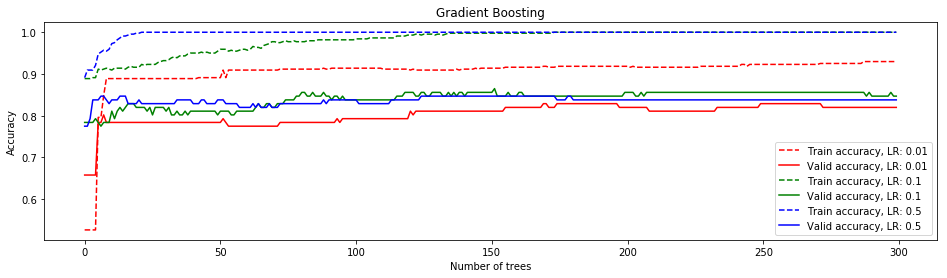

In [15]:
wide_fig_size = (16, 4)
plt.rcParams["figure.figsize"] = wide_fig_size

staged_accuracies_gb = get_staged_accuracies(
    GradientBoostingClassifier,
    learning_rates=[0.01, 0.1, 0.5]
)
accuracy_gb, n_trees_gb, lr_gb = get_best_params(staged_accuracies_gb)
print(
    "Gradient Boosting: best valid accuracy={}"
    "with {} trees and learning rate={}"
    .format(accuracy_gb, n_trees_gb, lr_gb)
)
plot_accuracies(staged_accuracies_gb, title="Gradient Boosting")


As suspected, we won’t be needing all 300 trees to perform well. 152 base models with a learning rate of 0.1 will do the trick.

We will also call this function on an AdaBoost model. Remember that it usually favors learning rates that are slightly higher.

AdaBoost: best valid accuracy=0.8918918918918919with 39 trees and learning rate=0.8


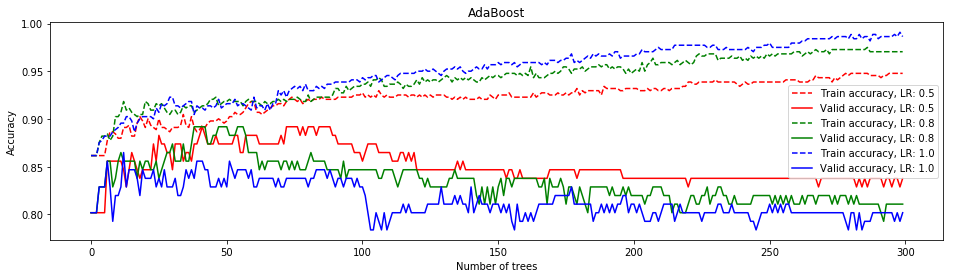

In [16]:
staged_accuracies_ab = get_staged_accuracies(
    AdaBoostClassifier,
    learning_rates=[0.5, 0.8, 1.0]
)
accuracy_ab, n_trees_ab, lr_ab = get_best_params(staged_accuracies_ab)
print(
    "AdaBoost: best valid accuracy={}"
    "with {} trees and learning rate={}"
    .format(accuracy_ab, n_trees_ab, lr_ab)
)
plot_accuracies(staged_accuracies_ab, title="AdaBoost")

We’ve got an optimal number of trees and learning rate, so now it’s high time we tuned the other hyperparameters. Let’s once again turn to our awesome Python and scikit-learn tandem to do the trick.

There are plenty of different suggested recommendations on picking the right parameters. We’ll use a set of potentially good parameters from the table available [here](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/).

We’ll perform a so-called “grid search,” meaning we’ll try every possible combination of these parameters, and pick the one that performs best.

During the grid search, [cross-validation](http://www.ritchieng.com/machine-learning-cross-validation/) is performed. At first, a training set is divided into $n$ even parts (defined by the `cv` keyword). Then there are $n$ turns when one part is used as a validation set and the rest is used as training set.

After $n$ validation turns, a mean score (e.g. accuracy) is computed, so the best model can be picked. Scikit-learn provides a handy API to do so. We can get the best-performing model retrained on a full training set easily.

Note: this code may take a bit longer (up to 90 seconds). If you are impatient, delete some values to minimize the number of combinations (e.g. the maximum values for `max_depth` and `max_features`).

In [17]:
from sklearn.model_selection import GridSearchCV

NUM_FOLDS = 5

gradient_boosting_params = {
    "n_estimators": [152],
    "learning_rate": [0.1],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.4, 0.6, 0.8, 1.0],
    "max_features": [0.5, 0.75, 1.0]
}

random_search = GridSearchCV(
    estimator=GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
    param_grid=gradient_boosting_params,
    cv=NUM_FOLDS
)
random_search.fit(features_train, labels_train)
best_gb_model = random_search.best_estimator_
best_gb_params = random_search.best_params_

In [18]:
best_gb_params

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 0.75,
 'n_estimators': 152,
 'subsample': 1.0}

To up the ante, we’ll leave evaluating the accuracy of our tuned model for later. First, let’s tune the random forest and AdaBoost.

If you don’t have such a table with hyperparameters at our disposal, or it just completely fails on your data, there is an alternative: **random search.**

This algorithm is trivial. You just define search ranges, then randomly pick several sets of parameters. What’s more, it can even give you better results than the grid search!

At first, this may sound strange, but just look at the image below, taken from this [this paper](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf). The green curve at the top and the yellow one to the left are functions of accuracy in each instance.

The grid search ensures even coverage of this two-dimensional space, yet it covers only three points on each hyperparameter space. When we use random search, we get much better search coverage of each individual hyperparameter. It is especially useful when a given metric function has evident peaks with respect to certain hyperparameters.

<img src="http://cs231n.github.io/assets/nn3/gridsearchbad.jpeg" alt="Drawing" style="width: 500px;"/>

Now, let’s define the ranges of interest for the remaining classifiers, and number of random trials (equal to the combinations in the previous grid search).

In [19]:
from functools import reduce
from operator import mul

random_trials = reduce(
    mul,
    (
        len(values)
        for _, values in gradient_boosting_params.items()
    )
)

random_forest_params = {
    "n_estimators": range(5, 500),
    "min_samples_split": range(2, 50),
    "max_features": [x / 10 for x in range(1, 11)]
}

adaboost_params = {
    "n_estimators": range(25, 50),
    "learning_rate": [x / 100 for x in range(80, 101)],
    "base_estimator__max_depth": range(1, 3),   
}

Let’s also define a function to retrieve the best model based on random search.

In [20]:
from sklearn.model_selection import RandomizedSearchCV

def find_best_model_random_search(model, params):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=random_trials,
        cv=NUM_FOLDS,
        random_state=RANDOM_STATE
    )
    random_search.fit(features_train, labels_train)
    return random_search.best_estimator_

Finally, let’s find the best hyperparameters for the random forest and AdaBoost. Then, we’ll compare those with gradient boosting.

Note that we have to define the AdaBoost base model in order to tinker with its parameters.

Again, the hyperparameter search can take some time (up to 170 seconds), so be patient when you run it.

In [21]:
best_rf_model = find_best_model_random_search(
    model=RandomForestClassifier(
        random_state=RANDOM_STATE
    ),
    params=random_forest_params
)
best_ab_model = find_best_model_random_search(
    model=AdaBoostClassifier(
        DecisionTreeClassifier(),
        random_state=RANDOM_STATE
    ),
    params=adaboost_params
)
                         
evaluate_models([best_rf_model, best_ab_model, best_gb_model])

RandomForestClassifier  AdaBoostClassifier  \
Train accuracy                0.956522            0.896739   
Test accuracy                 0.884058            0.869565   

                GradientBoostingClassifier  
Train accuracy                    1.000000  
Test accuracy                     0.905797

Hooray! We have slight improvements on each of our classifiers.

You can, of course, try different hyperameter ranges or use random search with gradient boosting. Plus, let’s not forget that there are many more parameters you can tune.

But I’d argue that these are the ones you should start with. They represent different aspects of our models and are rather easy to interpret.

There is also a somewhat smarter way to do hyperparameter search. It uses Bayesian optimization, and as an added bonus allows you to [use scikit-learn for implementation](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/). The topic is outside the scope of this text, so I’ll leave it at that, but it’s definitely something worth exploring.



### Summary

After reading this article, you should have some high-level understanding of ensembling methods. Also, I hope you’ll agree that using scikit-learn for implementation is quite fun!

Here’s a quick recap of what we’ve learned:

* **Decision trees are high-variance models, but we can fix this issue by using ensembles.**
* **Two main groups of ensembling methods are bagging (random forests) and boosting (AdaBoost and gradient tree boosting).**
* **Scikit-learn provides an easy API to train ensemble models with reasonable out-of-the-box quality.**
* **A little bit of digging into model hyperparameters can help us improve our models.**

Should this post inspire you to take a deep dive into the vast world of machine learning in Python, make sure to check out the links I’ve left for you throughout the text. I found them very useful and helpful while I was putting this piece together.

But if you’re new to the machine learning game and looking for a place to start, [look no further than this tutorial](https://stxnext.com/blog/2017/12/12/getting-started-machine-learning-python/) by two of my colleagues and ML experts at STX Next. They cover everything you need to begin your ML adventure in Python.